# PREDICTING THE PRIMARY CONTRIBUTORY CAUSE OF CAR ACCIDENTS

<img src="./Chicago_image.jpg" style="width:100%; height:auto;">

## Problem Statement
*   Car accidents are a significant public safety concern in Chicago, leading to injuries, fatalities, and substantial economic costs. Understanding the primary causes of these accidents can help the city implement targeted interventions to reduce crash rates and improve road safety. The goal of this project is to build a predictive model that accurately identifies the primary contributory cause of car accidents using available crash data, including information about vehicles, drivers, road conditions, and other relevant factors.

## Objectives:
#### 1. Data Exploration and Preprocessing:
* Explore and clean the Chicago crash datasets to identify and address issues like missing values, outliers, and inconsistent data entries.
#### 2.  Feature Selection and Engineering:
* Select and engineer relevant features that contribute significantly to predicting the cause of crashes.
* Reduce dimensionality if necessary to improve model performance and interpretability
#### 3. Model Development:
* Develop and train a multi-class classification model to predict the primary contributory cause of car accidents.
* Experiment with different models (e.g., Random Forest, Logistic Regression) to identify the best-performing model.
#### 4. Evaluation and Optimization:
* Evaluate the model's performance using appropriate metrics (e.g., F1-score, precision, recall, accuracy etc).
* Optimize the model through hyperparameter tuning and cross-validation to ensure it generalizes well to unseen data.
#### 5. Insights and Pattern Recognition:
* Analyze the model's predictions to identify patterns or common factors associated with specific crash causes.
* Use the model to provide actionable insights that can inform policy decisions, road safety initiatives, or public awareness campaigns.
#### 6. Deployment and Application:
* Consider how the model can be deployed as part of a decision-support system for city planners, law enforcement, or public safety officials.


## Data Understanding
1. `Traffic_Crashes_-_People_20240824.csv` from [ Driver/Passenger Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data)
    * This data contains information about `people` involved in a crash and if `any injuries` were sustained. Each record corresponds to an `occupant` in a vehicle listed in the `Vehicle` dataset. Some people involved in a crash may not have been an occupant in a motor vehicle, but may have been a `pedestrian`,`bicyclist`, or using `another non-motor vehicle` mode of transportation. Injuries reported are reported by the responding police officer.

2. `Traffic_Crashes_-_Vehicles_20240824.csv` from [ Vehicle Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3/about_data)

   * This dataset contains information about `vehicles` (or units as they are identified in crash reports) involved in a traffic crash. Vehicle information includes `motor vehicle` and `non-motor vehicle` modes of transportation, such as bicycles and pedestrians. Each mode of transportation involved in a crash is a `unit` and get one entry here. Each vehicle, each pedestrian, each motorcyclist, and each bicyclist is considered an `independent unit` that can have a trajectory separate from the other units. However, people inside a vehicle including the `driver` do not have a trajectory separate from the vehicle in which they are travelling and hence only the vehicle they are travelling in get any entry here.

## Importing the necessary libraries

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,\
precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score


In [95]:
people_df = pd.read_csv("Data/Traffic_Crashes_-_People_20240824.csv", low_memory=False)
people_df.head(2)

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [96]:
vehicle_df = pd.read_csv("Data/Traffic_Crashes_-_Vehicles_20240824.csv", low_memory=False)
vehicle_df.head(2)

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,1727162,f5943b05f46b8d4148a63b7506a59113eae0cf1075aabc...,12/21/2023 08:57:00 AM,2,PEDESTRIAN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1717556,7b1763088507f77e0e552c009a6bf89a4d6330c7527706...,12/06/2023 03:24:00 PM,1,DRIVER,NaN,1634931.0,NaN,NISSAN,SENTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data Exploration

In [97]:
columns_list = people_df.columns.tolist()
print(columns_list)

['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID', 'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']


In [98]:
columns_list2 = vehicle_df.columns.tolist()
print(columns_list2)

['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO', 'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO', 'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'VEH

In [99]:
print(f'Total number of rows in people_df: {people_df.shape}')
print(f'Total number of rows in vehicle_df: {vehicle_df.shape}')

Total number of rows in people_df: (1901033, 29)
Total number of rows in vehicle_df: (1766075, 71)


#### Merge the two datasets

* The VEHICLE_ID column in the people_df corresponds with the CRASH_UNIT_ID from the Vehicle df and we can merge the two datasets and if there are no matching values between `VEHICLE_ID` and `CRASH_UNIT_ID`, those rows will be excluded from the resulting DataFrame 

In [100]:
merged_df = pd.merge(people_df, vehicle_df, left_on='VEHICLE_ID', right_on='CRASH_UNIT_ID')
merged_df.shape

(1739998, 100)

#### Drop columns with large number of nulls

* Drop all rows with nulls exceeding a threshold of 30%

In [101]:
threshold = 0.3
merged_cleaned = merged_df.dropna(thresh=int((1-threshold) * len(merged_df)), axis=1)
cols = merged_cleaned.columns.tolist()
print(cols)

['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID_x', 'VEHICLE_ID_x', 'CRASH_DATE_x', 'CITY', 'STATE', 'SEX', 'AGE', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT', 'CRASH_UNIT_ID', 'CRASH_RECORD_ID_y', 'CRASH_DATE_y', 'UNIT_NO', 'UNIT_TYPE', 'VEHICLE_ID_y', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT']


* Drop columns that are not necessary for our analysis.
* Check the remaining columns for nulls which will be imputed in the data preprocessing.
* Check the datatypes and if there are any inconsistencies

In [102]:
columns_to_drop = ['UNIT_NO', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT', 'CRASH_RECORD_ID_x', 'BAC_RESULT','PERSON_ID',
                   'CRASH_DATE_y', 'CRASH_RECORD_ID_y', 'VEHICLE_ID_x', 'CRASH_UNIT_ID', 'VEHICLE_ID_y', 'MODEL',
                   'LIC_PLATE_STATE', 'CITY', 'STATE']
final_df = merged_cleaned.drop(columns_to_drop, axis=1)
final_df.shape

(1739998, 19)

In [103]:
final_df.isnull().sum()

PERSON_TYPE                   0
CRASH_DATE_x                  0
SEX                       28692
AGE                      513022
SAFETY_EQUIPMENT            308
AIRBAG_DEPLOYED             310
EJECTION                    313
INJURY_CLASSIFICATION       372
DRIVER_ACTION            359050
DRIVER_VISION            359048
PHYSICAL_CONDITION       359049
UNIT_TYPE                  2260
MAKE                      39691
VEHICLE_YEAR             312175
VEHICLE_DEFECT            39686
VEHICLE_TYPE              39686
VEHICLE_USE               39686
TRAVEL_DIRECTION          39686
MANEUVER                  39686
dtype: int64

In [104]:
final_df.dtypes

PERSON_TYPE               object
CRASH_DATE_x              object
SEX                       object
AGE                      float64
SAFETY_EQUIPMENT          object
AIRBAG_DEPLOYED           object
EJECTION                  object
INJURY_CLASSIFICATION     object
DRIVER_ACTION             object
DRIVER_VISION             object
PHYSICAL_CONDITION        object
UNIT_TYPE                 object
MAKE                      object
VEHICLE_YEAR             float64
VEHICLE_DEFECT            object
VEHICLE_TYPE              object
VEHICLE_USE               object
TRAVEL_DIRECTION          object
MANEUVER                  object
dtype: object

In [105]:
mixed_types = final_df.map(type).nunique() > 1
print(final_df.columns[mixed_types].tolist())

['SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE', 'MAKE', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER']


#### Using regular expressions to convert inconsistent data types
* This will clear spaces and any other punctuations in the dataset hence creating uniformity in the data types.

In [106]:
import re

def clean_string(s):
    if isinstance(s, str):
        s = re.sub(r'[^\w\s\<\>]', '', s)  # Remove punctuation
        s = re.sub(r'\s+', '_', s)     # Replace multiple spaces with a single space
    return s

final_df = final_df.map(clean_string)


## Visualization

#### A graph showing the counts of Injury Classifications

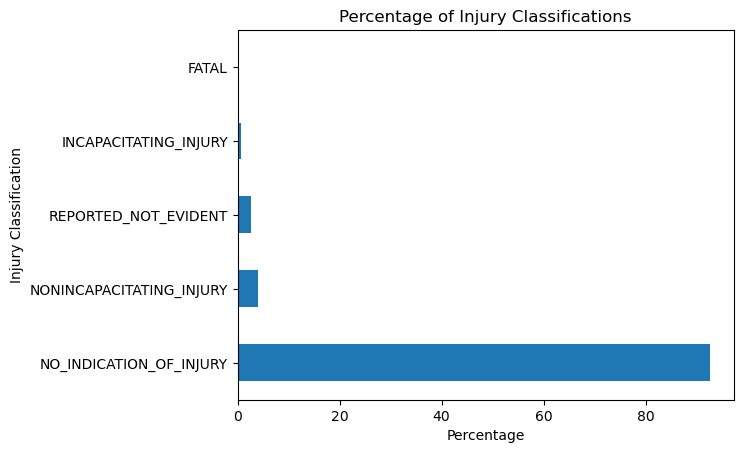

Plot saved as Images/Percentage_of_Injury_Classifications.png


In [107]:
counts = final_df['INJURY_CLASSIFICATION'].value_counts(normalize=True)
counts
percentage_counts = counts*100
ax = percentage_counts.plot.barh()


plt.xlabel('Percentage')
plt.ylabel('Injury Classification')
plt.title('Percentage of Injury Classifications')

image_path = 'Images/Percentage_of_Injury_Classifications.png'
plt.savefig(image_path, bbox_inches='tight')
plt.show()
print(f"Plot saved as {image_path}")

* From the above graph we can see that the column `INJURY_CLASSIFICATION` has imbalances where most of the data falls on the category `NO_INDICATION_OF_INJURY`

####  A graph showing Count of Males and Females in Each Age Group

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Plot saved as Images/Count_of_Males_and_Females_in_Each_Age_Group.png


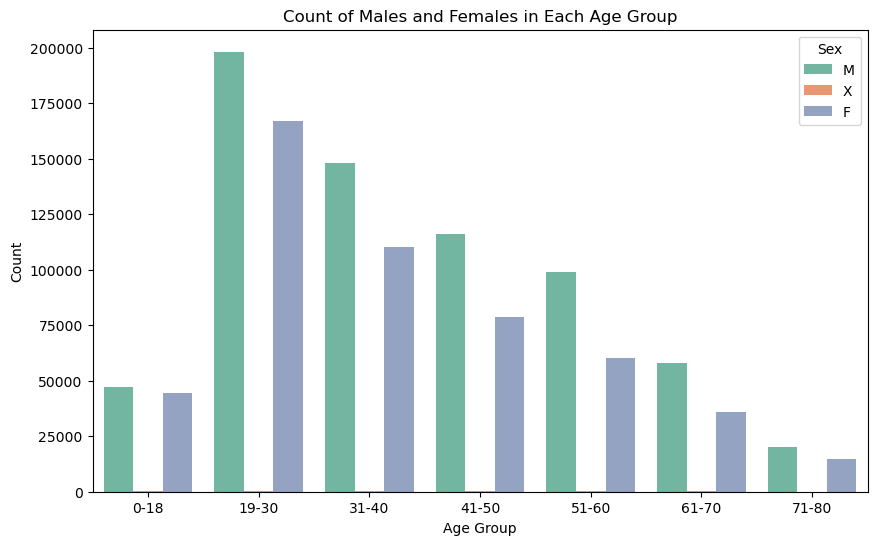

In [108]:
# Define age bins and labels
age_bins = [0, 18, 30, 40, 50, 60, 70, 80]
age_labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80']

# Bin the ages
final_df['Age Group'] = pd.cut(final_df['AGE'], bins=age_bins, labels=age_labels)

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(x=final_df['Age Group'], hue='SEX', data=merged_df, palette='Set2')

# Adding labels and title
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Count of Males and Females in Each Age Group')
plt.legend(title='Sex')
image_path = 'Images/Count_of_Males_and_Females_in_Each_Age_Group.png'
plt.savefig(image_path, bbox_inches='tight')
print(f"Plot saved as {image_path}")
plt.show()


* From the above graph, the individuals both `males and females` between age `19-30` were the most involved in car crashes.
* `Males` in this age group had the highest occurrences with over 180000 crashes while over 170000 `Females` in the same age_group of `19-30` had a crash.

#### Plotting the Count of Injury Classifications by Sex

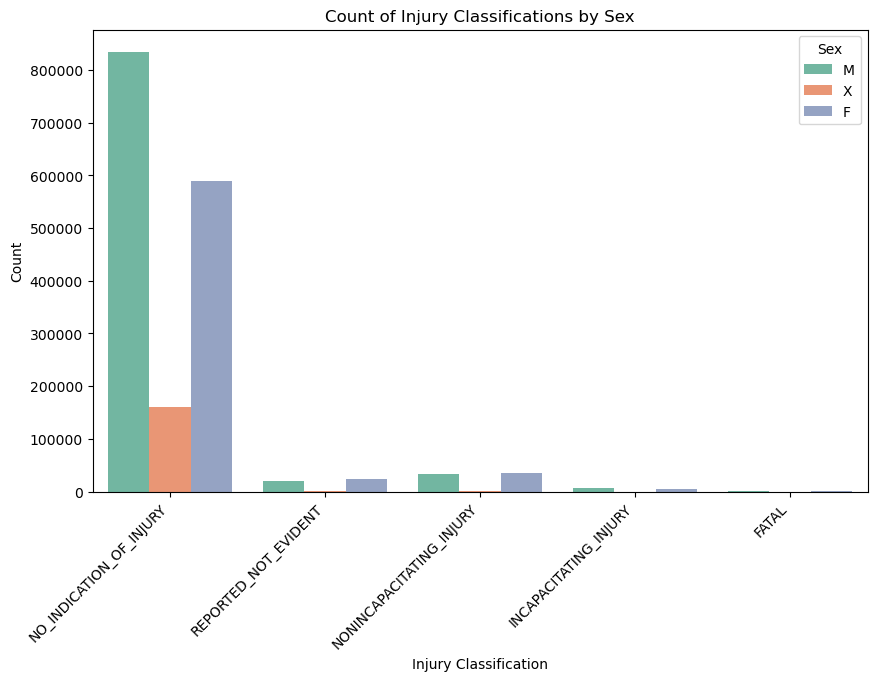

Plot saved as Images/Count_of_Injury_Classifications_by_Sex.png


In [109]:
plt.figure(figsize=(10, 6))
sns.countplot(x='INJURY_CLASSIFICATION', hue='SEX', data=final_df, palette='Set2')

# Adding labels and title
plt.xlabel('Injury Classification')
plt.ylabel('Count')
plt.title('Count of Injury Classifications by Sex')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sex')
image_path = 'Images/Count_of_Injury_Classifications_by_Sex.png'
plt.savefig(image_path, bbox_inches='tight')
plt.show()
print(f"Plot saved as {image_path}")

* This graph shows the imbalance in the classifications with the class `NO_INDICATION_OF_INJURY` getting a large sample and `FATAL` getting the smallest sample.
* From the graph `MALES` have high occurrences in all the five classes followed by `FEMALES`.

#### A Piechart showing percentages of the gender distribution. 

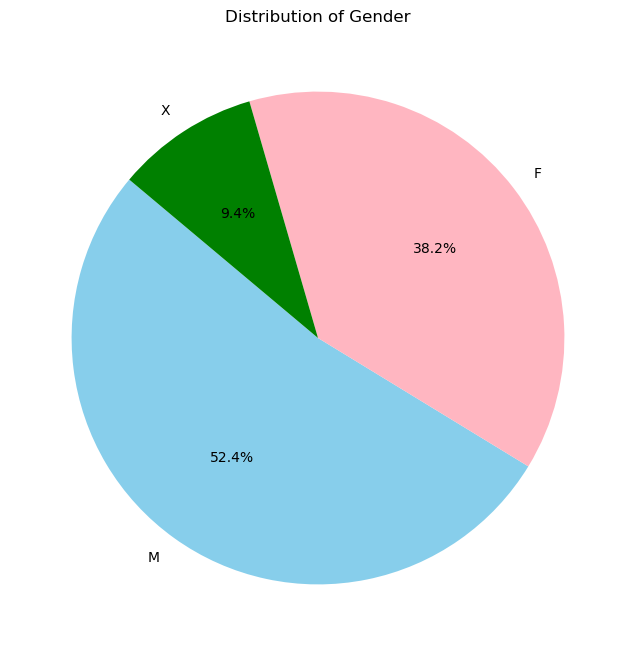

Plot saved as Images/Distribution_of_Gender.png


In [110]:
sex_counts = final_df['SEX'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightpink', 'green'])

# Adding a title
plt.title('Distribution of Gender')
image_path = 'Images/Distribution_of_Gender.png'
plt.savefig(image_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"Plot saved as {image_path}")

* The datasets had a larger sample of males involved in accidents compared to other gender with a leading percentage of `52.4%` which is more than half of the dataset.
* The females had a `38.2%` while X a non-binary or gender non-conforming identity had `9.4%`

#### A graph showing Percentage of Physical Condition Classifications

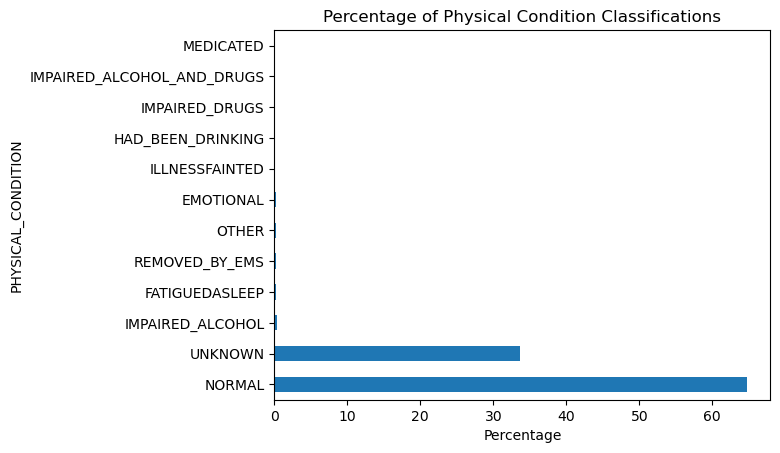

Plot saved as Images/Percentage_of_Physical_Condition_Classifications.png


In [111]:
percentages = final_df['PHYSICAL_CONDITION'].value_counts(normalize=True)*100
ax = percentages.plot.barh()


plt.xlabel('Percentage')
plt.ylabel('PHYSICAL_CONDITION')
plt.title('Percentage of Physical Condition Classifications')

image_path = 'Images/Percentage_of_Physical_Condition_Classifications.png'
plt.savefig(image_path, bbox_inches='tight')
plt.show()
print(f"Plot saved as {image_path}")

* The `NORMAL` classification had the highest percentage with over `65%` which shows that more than `65%` crashes people involved were in normal conditions.

#### Examining the columns.
* Let's check which columns are good for our model training.
* Drop the columns that are redudant to reduce the dataset.

In [19]:
columns_list = final_df.columns.tolist()
print(columns_list)

['PERSON_TYPE', 'CRASH_DATE_x', 'SEX', 'AGE', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE', 'MAKE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER', 'Age Group']


In [20]:
columns_to_drop = ['MAKE', 'CRASH_DATE_x', 'VEHICLE_YEAR', 'Age Group',]
modelling_df = final_df.drop(columns_to_drop, axis=1)
modelling_df.shape

(1739998, 16)

#### Check for Numerical columns and categorical columns
* Define a `function` to `grab_numeric` and `grab_categorical` columns from a dataframe.
* This helps in understanding the dataset before modelling and cleaning.
* The dataframe used for modelling has been named `modelling_df`.
* This is the dataframe we are passing to the Machine learning models.

In [21]:
def grab_numeric(df):
    """Select numeric columns from the DataFrame."""
    return df.select_dtypes(include=['float64', 'int']).columns

def grab_categorical(df):
    """Select categorical columns from the DataFrame."""
    return df.select_dtypes(include=['object']).columns

In [22]:
numeric_feature_names = grab_numeric(modelling_df)
numeric_feature_names


Index(['AGE'], dtype='object')

In [23]:
categorical_feature_names = grab_categorical(modelling_df).drop('INJURY_CLASSIFICATION')
categorical_feature_names

Index(['PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER'],
      dtype='object')

#### The `modeling_df`
* The modelling_df has only one numerical column which is `AGE`.
* The categorical columns are: `'PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER'`

In [24]:
modelling_df.head()

,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,UNIT_TYPE,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER
0,DRIVER,M,25.0,NONE_PRESENT,DEPLOYMENT_UNKNOWN,NONE,NO_INDICATION_OF_INJURY,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,NONE,PASSENGER,PERSONAL,N,TURNING_RIGHT
1,DRIVER,M,37.0,SAFETY_BELT_USED,DID_NOT_DEPLOY,NONE,NO_INDICATION_OF_INJURY,NONE,NOT_OBSCURED,NORMAL,DRIVER,NONE,PASSENGER,PERSONAL,E,STRAIGHT_AHEAD
2,DRIVER,X,NaN,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,NONE,NO_INDICATION_OF_INJURY,IMPROPER_BACKING,UNKNOWN,UNKNOWN,PARKED,NONE,PASSENGER,NOT_IN_USE,S,PARKED
3,DRIVER,X,NaN,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,UNKNOWN,NO_INDICATION_OF_INJURY,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,NONE,PASSENGER,TAXIFOR_HIRE,N,OTHER
4,DRIVER,X,NaN,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,UNKNOWN,NO_INDICATION_OF_INJURY,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,NONE,PASSENGER,PERSONAL,W,STRAIGHT_AHEAD


## Modelling

* Let's split the data from the `modelling_df` into `train` and `test` sets with a `test_size` of `20%` and `random_state=42`.
* Our `Target` column is `INJURY_CLASSIFICATION` and we will drop it when selecting our `Feature variables` to avoid `data leakage` when training the models.
* We will use `train_test_split` from `scikit-learn` to split the data into training and test sets.

In [25]:
X = modelling_df.drop(columns=["INJURY_CLASSIFICATION"], axis=1)
y = modelling_df["INJURY_CLASSIFICATION"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Data Preprocessing

#### Check and impute the Missing Values
* We will begin with imputing the nullvalues since the `modelling_df` had missing values
* Let's begin with the target variable y.
* Check both `y_train` and `y_test` for `null` values

In [26]:
y_train.isna().sum()

297

In [27]:
y_test.isna().sum()

75

In [28]:
y_train.shape

(1391998,)

#### Dealing with null values.
* We have seen that the train and test set of our `target` variable have null values.
* Imputing these values can cause `data leakage` because the goal is to use `y_test` as an `untouched`, `unbiased sample` to `evaluate` the model's `generalization` to `new data`.
* Therefore `imputation` in the `y_train` and the `y_test` is highly discouraged.
* From the dataset we can see there are few `missing values`and `dropping the rows` would not have a big impact on our dataset since we have `1391998` rows in our dataset.
* However, the `dropped rows` from our `target variable` should be `dropped` from our `features` to maintain alignment between the `features` and the `target variable` to avoid `incorrect predictions`.  

#### Identifying null indices.
* Let's identify the `null indices` from our `target` variable and `align` them with `corresponding indices` from `feature variables`.
* Then `drop nulls` from both the `target` variable and the `feature` variables.


In [29]:
y_train_null_indices = y_train[y_train.isnull()].index
X_train = X_train.drop(y_train_null_indices, axis=0)
y_train = y_train.drop(y_train_null_indices, axis=0)

In [30]:
y_test_null_indices = y_test[y_test.isnull()].index
X_test = X_test.drop(y_test_null_indices, axis=0)
y_test = y_test.drop(y_test_null_indices, axis=0)

* Let's check for nulls and the shape of our target.

In [31]:
y_train.isna().sum()

0

In [32]:
y_test.isna().sum()

0

In [33]:
y_train.shape

(1391701,)

* We have dropped over 200 columns from the target variable and it should correspond to our `feature variables`.

In [34]:
print(f'{X_train.shape}: Perfect!!!!!!!!')

(1391701, 15): Perfect!!!!!!!!


#### Imputing the `Feature` variables
* Instantiate a MissingIndicator and fit it to the train data.

In [35]:
from sklearn.impute import MissingIndicator
indicator_demo = MissingIndicator()

indicator_demo.fit(X_train)

indicator_demo.features_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [36]:
X_train.isna().sum()

PERSON_TYPE                0
SEX                    22699
AGE                   410138
SAFETY_EQUIPMENT          15
AIRBAG_DEPLOYED           19
EJECTION                  21
DRIVER_ACTION         287272
DRIVER_VISION         287271
PHYSICAL_CONDITION    287272
UNIT_TYPE               1811
VEHICLE_DEFECT         31651
VEHICLE_TYPE           31651
VEHICLE_USE            31651
TRAVEL_DIRECTION       31651
MANEUVER               31651
dtype: int64

In [37]:
indicator_demo.transform(X_train)[:, 1:15]

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [38]:
X_train.iloc[:5, [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]

,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,UNIT_TYPE,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER
342724,M,31.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,NOT_OBSCURED,NORMAL,PEDESTRIAN,NaN,NaN,NaN,NaN,NaN
1300050,M,44.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,UNKNOWN,PASSENGER,PERSONAL,E,STRAIGHT_AHEAD
1317000,M,53.0,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,NONE,OTHER,UNKNOWN,UNKNOWN,DRIVER,NONE,SPORT_UTILITY_VEHICLE_SUV,PERSONAL,S,STRAIGHT_AHEAD
1699391,NaN,NaN,NONE_PRESENT,DEPLOYMENT_UNKNOWN,UNKNOWN,NaN,NaN,NaN,PEDESTRIAN,NaN,NaN,NaN,NaN,NaN
1400401,F,25.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,NONE,NOT_OBSCURED,NORMAL,DRIVER,NONE,PASSENGER,PERSONAL,S,OTHER


In [39]:
indicator = MissingIndicator(features="all")
indicator.fit(X_train)

MissingIndicator(features='all')


* Create a Helper function for transforming features
    
*  For every feature in X, create another feature indicating whether that feature
    is missing. (This doubles the number of columns in X.)
    
    
*  Create a 2D array of True and False values indicating whether a given feature
    is missing for that row

In [40]:
def add_missing_indicator_columns(X, indicator):
   
    missing_array_bool = indicator.transform(X)
    
    # transform into 1 and 0 for modeling
    missing_array_int = missing_array_bool.astype(int)
    
    # helpful for readability but not needed for modeling
    missing_column_names = [col + "_missing" for col in X.columns]
    
    # convert to df so it we can concat with X
    missing_df = pd.DataFrame(missing_array_int, columns=missing_column_names, index=X.index)
    
    return pd.concat([X, missing_df], axis=1)

In [41]:
X_train = add_missing_indicator_columns(X=X_train, indicator=indicator)

In [42]:
X_train.head()

,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,UNIT_TYPE,...,EJECTION_missing,DRIVER_ACTION_missing,DRIVER_VISION_missing,PHYSICAL_CONDITION_missing,UNIT_TYPE_missing,VEHICLE_DEFECT_missing,VEHICLE_TYPE_missing,VEHICLE_USE_missing,TRAVEL_DIRECTION_missing,MANEUVER_missing
342724,DRIVER,M,31.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,NOT_OBSCURED,NORMAL,PEDESTRIAN,...,0,0,0,0,0,1,1,1,1,1
1300050,DRIVER,M,44.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,UNKNOWN,UNKNOWN,UNKNOWN,DRIVER,...,0,0,0,0,0,0,0,0,0,0
1317000,DRIVER,M,53.0,USAGE_UNKNOWN,DEPLOYMENT_UNKNOWN,NONE,OTHER,UNKNOWN,UNKNOWN,DRIVER,...,0,0,0,0,0,0,0,0,0,0
1699391,PASSENGER,NaN,NaN,NONE_PRESENT,DEPLOYMENT_UNKNOWN,UNKNOWN,NaN,NaN,NaN,PEDESTRIAN,...,0,1,1,1,0,1,1,1,1,1
1400401,DRIVER,F,25.0,SAFETY_BELT_USED,NOT_APPLICABLE,NONE,NONE,NOT_OBSCURED,NORMAL,DRIVER,...,0,0,0,0,0,0,0,0,0,0


In [43]:
numeric_feature_names = ["AGE"]
categorical_feature_names = ['PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER']

X_train_numeric = X_train[numeric_feature_names]
X_train_categorical = X_train[categorical_feature_names]

* From scikit learn library import SimpleImputer
* Fit the imputer to the X_train

In [44]:
from sklearn.impute import SimpleImputer
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer()

In [45]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(X_train_categorical)

SimpleImputer(strategy='most_frequent')

* Given a DataFrame and an imputer, use the imputer to fill in all missing values in the DataFrame

In [46]:
def impute_missing_values(X, imputer):
    
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [47]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)

In [48]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

AGE                   0
PERSON_TYPE           0
SEX                   0
SAFETY_EQUIPMENT      0
AIRBAG_DEPLOYED       0
EJECTION              0
DRIVER_ACTION         0
DRIVER_VISION         0
PHYSICAL_CONDITION    0
UNIT_TYPE             0
VEHICLE_DEFECT        0
VEHICLE_TYPE          0
VEHICLE_USE           0
TRAVEL_DIRECTION      0
MANEUVER              0
dtype: int64

In [49]:
X_train = X_train.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_train = pd.concat([X_train_imputed, X_train], axis=1)

In [50]:
X_train.isna().sum()

AGE                           0
PERSON_TYPE                   0
SEX                           0
SAFETY_EQUIPMENT              0
AIRBAG_DEPLOYED               0
EJECTION                      0
DRIVER_ACTION                 0
DRIVER_VISION                 0
PHYSICAL_CONDITION            0
UNIT_TYPE                     0
VEHICLE_DEFECT                0
VEHICLE_TYPE                  0
VEHICLE_USE                   0
TRAVEL_DIRECTION              0
MANEUVER                      0
PERSON_TYPE_missing           0
SEX_missing                   0
AGE_missing                   0
SAFETY_EQUIPMENT_missing      0
AIRBAG_DEPLOYED_missing       0
EJECTION_missing              0
DRIVER_ACTION_missing         0
DRIVER_VISION_missing         0
PHYSICAL_CONDITION_missing    0
UNIT_TYPE_missing             0
VEHICLE_DEFECT_missing        0
VEHICLE_TYPE_missing          0
VEHICLE_USE_missing           0
TRAVEL_DIRECTION_missing      0
MANEUVER_missing              0
dtype: int64

## OneHotEncoding

#### Helper function for transforming training data.  
* It takes in the full X dataframe and feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe with that feature transformed into multiple columns of 1s and 0s
* We will use encoder = OneHotEncoder(sparse_output = True)
* Make a one-hot encoder and fit it to the training data.
* Then call helper function that actually encodes the feature and concats it

In [51]:
def encode_and_concat_feature_train(X_train, feature_name):
    
    
    ohe = OneHotEncoder(sparse_output = True, categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
   
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

* We create a helper function for transforming a feature into multiple columns of 1s and 0s. Used
in both training and testing steps.  Takes in the full X dataframe, feature name, and encoder, 
and returns the dataframe with that feature transformed into multiple columns of 1s and 0s
* create new one-hot encoded df based on the feature

In [52]:
def encode_and_concat_feature(X, feature_name, ohe):
   
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [53]:
encoders = {}

for categorical_feature in categorical_feature_names:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [54]:
X_train.shape

(1391701, 208)

* After encoding our X_train, there is a significant increase of the columns from 15 to 208
  

#### Label encoding for our target variable
* We will use `LabelEncoder` from scikit-learn libraries to encode our `target` variable.
* Since this is a Multiclassification model, label encoding is suitable for the `target` variable because it maps each `category` to a `unique integer`, which the model can use `directly` to predict `class labels`

In [55]:
from sklearn.preprocessing import LabelEncoder
array = np.array(y_train)
y_train = pd.Series(array)

In [56]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train)

In [57]:
y_train.shape

(1391701,)

#### 1. Dummy Model
* We will start with a dummy model and fit it to our now imputed X_train andy_train

In [58]:
dummy_model = DummyClassifier(strategy = "most_frequent")

In [59]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

* With cross-validation we will see how the model would do in generalizing new data not presented to it before.

In [60]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results

array([0.92605473, 0.92605806, 0.92605806, 0.92605447, 0.92605447])

* The dummy model has a consistent accuracy of around 92.6% across the cross-validation folds.
* This indicates that the model correctly predicted the class labels for 92% of the instances in the dataset. This means that out of every 100 predictions, 92 were correct, and 8 were incorrect.
* The high accuracy suggests that the dataset might be imbalanced, meaning one class dominates the others.
* The dummy model might be predicting the majority class most of the time, leading to high accuracy but poor performance in terms of capturing minority classes.
* From our EDA analysis, our `target` variable and most of our `features` had imbalanced classes.


#### Model 2: DecisionTreeClassifier
* Let's use a `DecisionTreeClassifier` with max_depth=5 for performance comparison.

In [61]:
model1 = DecisionTreeClassifier(max_depth = 5)
model1.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

In [62]:
model1.score(X_train, y_train)

0.9270029984888996

In [63]:
cv_results = cross_val_score(model1, X_train, y_train, cv=5)
cv_results

array([0.92701039, 0.92695983, 0.92705324, 0.92694187, 0.92697061])

* Our decisiontree regressor has a high accuracy score of 92% across all folds. The model is either overfitting or biased.
* Due to the size of the data, a memory error is unavoidable.
* Let's try `feature reduction` for a better performance.

#### Feature Reduction
* Here we will focus only on relevant `features` to mitigate overfitting
* It will also help improve training time since fewer features mean less data for the model to process
* By identifying the most important variables helps eliminate `noise` leading to `better performance`.
* Let's identify the important features.

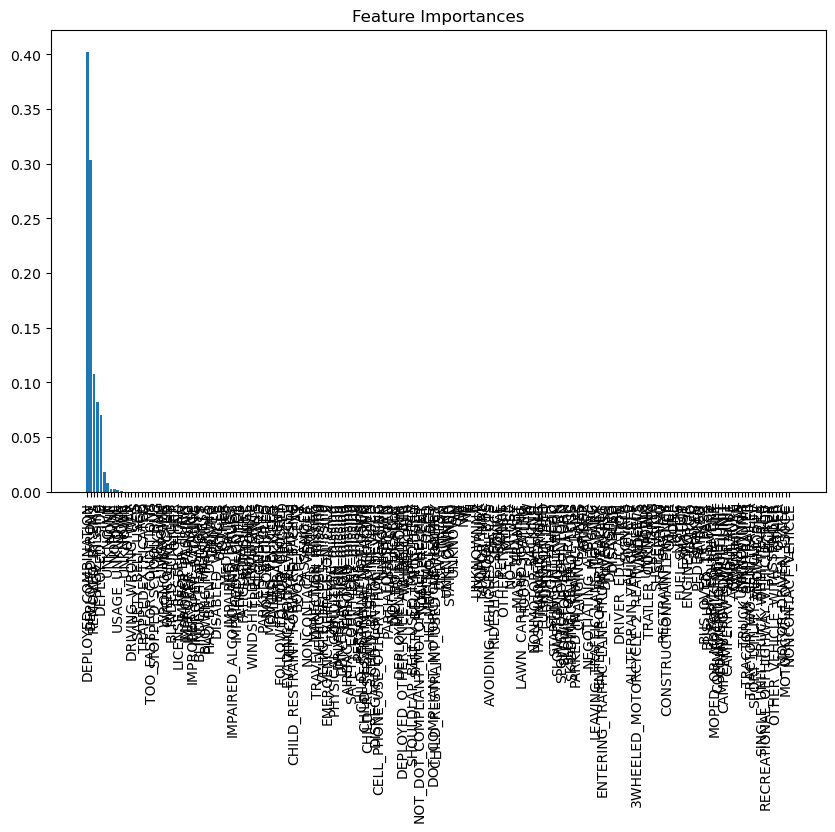

In [64]:
important_features=model1.feature_importances_
indices = np.argsort(important_features)[::-1]
# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), important_features[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

* The features should correspond column indices of both X_train and X_test
* So, we need to transform X_test in order to correspond with the X_train

### X_test Transformation
* Let's create a copy of the X_test and work on it.
* We will use the same transformers we used on the X_train

In [65]:
X_test_no_transformation = X_test.copy()

In [66]:
X_test_missing = add_missing_indicator_columns(X_test_no_transformation, indicator)

In [67]:
X_test_numeric = X_test_missing[numeric_feature_names]
X_test_categorical = X_test_missing[categorical_feature_names]

In [68]:
# Impute all Missing Values
X_test_numeric = impute_missing_values(X_test_numeric, numeric_imputer)
X_test_categorical = impute_missing_values(X_test_categorical, categorical_imputer)
X_test_imputed = pd.concat([X_test_numeric, X_test_categorical], axis=1)


In [69]:
X_test_new = X_test_missing.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_test_final= pd.concat([X_test_imputed, X_test_new], axis=1)

In [70]:
for categorical_feature in categorical_feature_names:
    X_test_final = encode_and_concat_feature(X_test_final,
                                       categorical_feature, encoders[categorical_feature])

In [71]:
X_test_final = X_test_final.reindex(columns=X_train.columns, fill_value=0)

In [72]:
threshold = 0.01
top_indices = np.where(important_features > threshold)[0]
X_train_reduced = X_train.iloc[:, top_indices]
X_test_reduced = X_test_final.iloc[:, top_indices]

In [73]:
X_train_reduced.shape

(1391701, 6)

#### Model 3: Training the DecisionTreeClasifier
* Let's train the DecisionTreeClasifier using the reduced features and compare the performance

In [74]:
model3 = DecisionTreeClassifier(max_depth = 5)
model3.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=5)

* Let's create a class to save the model and more easily perform cross-validation and return results.


In [75]:
class ModelWithCV():
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()



    def cross_validate(self, X=None, y=None, kfolds=10):
        
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        
        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

In [76]:
model_after_feature_selection_results = ModelWithCV(
                            model3,
                            DecisionTreeClassifier,
                            X_train_reduced,
                            y_train

)         

In [77]:
model_results=model_after_feature_selection_results
model_results.print_cv_summary()

CV Results for `<class 'sklearn.tree._classes.DecisionTreeClassifier'>` model:
            0.92699 ± 0.00007 accuracy
        


* After feature reduction, the model maintains a mean accuracy of 92%
* let's try running a Logistic Regression model with regularization so we pass the penalty='l2'

####  Model 4: Introducing a LogisticRegression Model

In [78]:
simple_logreg_model = LogisticRegression(random_state=2021, penalty='l2')
simple_logreg_model.fit(X_train_reduced, y_train)

LogisticRegression(random_state=2021)

In [79]:
feature_importance = pd.Series(np.abs(simple_logreg_model.coef_[0]), index=X_train_reduced.columns).sort_values(ascending=False)
print(feature_importance)

F                       0.977655
DEPLOYED_COMBINATION    0.404507
AGE_missing             0.347520
REMOVED_BY_EMS          0.299424
DEPLOYED_FRONT          0.095676
DEPLOYED_SIDE           0.037232
dtype: float64


In [80]:
model_after_feature_selection_results = ModelWithCV(
                            simple_logreg_model,
                            DecisionTreeClassifier,
                            X_train_reduced,
                            y_train

)         

In [81]:
model_results=model_after_feature_selection_results
model_results.print_cv_summary()

CV Results for `<class 'sklearn.tree._classes.DecisionTreeClassifier'>` model:
            0.92701 ± 0.00006 accuracy
        


In [82]:
y_pred = simple_logreg_model.predict(X_test_reduced)

In [83]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00       125
   INCAPACITATING_INJURY       0.00      0.00      0.00      2281
NONINCAPACITATING_INJURY       0.56      0.03      0.05     14064
 NO_INDICATION_OF_INJURY       0.93      1.00      0.96    322297
    REPORTED_NOT_EVIDENT       0.00      0.00      0.00      9158

                accuracy                           0.93    347925
               macro avg       0.30      0.21      0.20    347925
            weighted avg       0.88      0.93      0.89    347925



C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Imbalance Issue:
* The model performs very well on the majority class "NO_INDICATION_OF_INJURY" but fails to perform adequately on the minority classes like "FATAL," "INCAPACITATING_INJURY," and others. This suggests that the model is heavily biased towards the majority class.
*  Further tuning might involve adjusting by refining the model's hyperparameters, using a more balanced dataset, or employing techniques like class weighting to improve the model's performance across all classes.


#### Model 5: Adjusting iterations

In [84]:
LogReg2 = LogisticRegression(class_weight='balanced', random_state = 42, penalty = 'l2', solver='saga', max_iter = 1000)
LogReg2.fit(X_train_reduced, y_train)

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [85]:
y_pred = LogReg2.predict(X_test_reduced)

In [86]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

                          precision    recall  f1-score   support

                   FATAL       0.01      0.33      0.01       125
   INCAPACITATING_INJURY       0.04      0.09      0.05      2281
NONINCAPACITATING_INJURY       0.24      0.12      0.16     14064
 NO_INDICATION_OF_INJURY       0.98      0.31      0.47    322297
    REPORTED_NOT_EVIDENT       0.03      0.75      0.06      9158

                accuracy                           0.31    347925
               macro avg       0.26      0.32      0.15    347925
            weighted avg       0.92      0.31      0.44    347925



#### Observations
* Class Detection: The model has improved in detecting minority classes like "FATAL" and "REPORTED_NOT_EVIDENT." This is reflected in the increased recall for these classes.
* Precision Trade-off: While recall improved for several classes, precision dropped, especially for "NO_INDICATION_OF_INJURY," which now has a much lower recall and F1-score.
* Accuracy Drop: The overall accuracy dropped significantly from 0.93 to 0.31. This is because the model is no longer heavily biased toward the majority class, leading to more errors overall.
* Macro Avg Improvement: The recall in the macro average improved, suggesting that the model is now better at detecting minority classes, though precision and F1-score still suffer.
* Weighted Avg: The weighted average metrics dropped, reflecting the poorer overall performance due to the loss in precision for the majority class.
* The model has improved in detecting minority classes, as seen by the increase in recall for "FATAL," "INCAPACITATING_INJURY," and "REPORTED_NOT_EVIDENT." However, this came at the cost of overall accuracy and precision, especially for the majority class "NO_INDICATION_OF_INJURY." The trade-off indicates a shift from a model that was highly accurate but biased towards the majority class, to one that is more balanced but less precise overall.



#### Model 6: Scaling

In [87]:
Scaler = StandardScaler()
Scaler.fit(X_train_reduced)

StandardScaler()

In [88]:
def scale_values(X, scaler):
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [89]:
X_train = scale_values(X_train_reduced, Scaler)

In [90]:
LogRegScaled = LogisticRegression(class_weight='balanced', random_state = 42, penalty = 'l2', solver='saga', max_iter = 1000)
LogRegScaled.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='saga')

In [91]:
X_test_scaled = scale_values(X_test_reduced, Scaler)

In [92]:
y_pred = LogReg2.predict(X_test_scaled)

In [93]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                   FATAL       0.00      0.63      0.00       125
   INCAPACITATING_INJURY       0.01      0.53      0.01      2281
NONINCAPACITATING_INJURY       0.20      0.04      0.07     14064
 NO_INDICATION_OF_INJURY       0.97      0.08      0.14    322297
    REPORTED_NOT_EVIDENT       0.00      0.00      0.00      9158

                accuracy                           0.08    347925
               macro avg       0.24      0.26      0.05    347925
            weighted avg       0.91      0.08      0.14    347925



C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Comparison: 

* Recall Improvement: After scaling, recall for the minority classes (e.g., "FATAL" and "INCAPACITATING_INJURY") improved significantly. For "FATAL," recall increased from 0.33 to 0.63, and for "INCAPACITATING_INJURY," from 0.09 to 0.53. This suggests that the model is now identifying more instances of these classes.
Precision Decrease:

* Precision for these classes dropped to nearly 0, indicating that while the model is identifying more instances, it is also making many incorrect predictions. This leads to very low precision, which is problematic for these minority classes.
Performance on Majority Class:

* For "NO_INDICATION_OF_INJURY," both precision and recall dropped significantly after scaling (precision from 0.98 to 0.97, recall from 0.31 to 0.08). This indicates that the model's ability to correctly predict the majority class has deteriorated.
Overall Accuracy:

* Accuracy dropped drastically from 0.31 before scaling to 0.08 after scaling. This indicates that the model's overall ability to correctly classify instances has decreased significantly.
Macro and Weighted Averages:

* The macro average F1-score decreased from 0.15 to 0.05, and the weighted average F1-score dropped from 0.44 to 0.14 after scaling. This suggests that the model's overall performance across all classes worsened after scaling.


1. Accuracy Comparison:
Original Model:
Accuracy: 93%
Interpretation: High accuracy, but it might be skewed due to class imbalance. The model is likely performing well on the majority class but poorly on the minority classes.
Further Trained Model (Before Scaling):
Accuracy: 31%
Interpretation: A significant drop in accuracy suggests the model may have learned better to handle minority classes but at the expense of overall accuracy. This could be due to a focus on minority classes that have lower support.
After Scaling:
Accuracy: 8%
Interpretation: The accuracy has dropped considerably, indicating the model struggles to generalize, especially after scaling, and may now be underfitting.
2. Precision, Recall, and F1-Score:
Original Model:
Likely has high precision and recall for the majority class (NO_INDICATION_OF_INJURY) but poor performance on minority classes (FATAL, INCAPACITATING_INJURY, etc.).
Further Trained Model (Before Scaling):
Shows improvement in recall for minority classes but with a trade-off in overall precision and accuracy.
F1-Score: Improvement in handling minority classes, but overall performance might be less reliable.
After Scaling:
Further deterioration in both precision and recall across most classes, indicating that scaling might not have been effective for this dataset.
3. Class Imbalance Consideration:
Original Model: Likely performing well for the dominant class, which inflates the accuracy.
Further Trained Model (Before Scaling): Slight improvement in minority classes, but at the cost of overall accuracy.
After Scaling: Model performs poorly across the board, indicating it’s struggling to find any consistent pattern.
4. You may also consider additional techniques like class weighting or SMOTE (Synthetic Minority Over-sampling Technique) to further improve handling of class imbalance.


#### Conclusion:
* Overall, the LogisticRegression model before scaling performed better. The drastic drop in precision, accuracy, and F1-scores after scaling suggests that while scaling helped with identifying minority classes, it did so at a considerable cost to overall model performance. Adjustments like further hyperparameter tuning, or exploring different scaling techniques, might help balance the trade-offs better.
* The feature "F" (indicating gender category for female) is the most influential factor in the model, suggesting that gender plays a significant role in the prediction of crash outcomes. This could imply that gender-related factors are closely associated with the primary causes of crashes and injury severity.
* The features related to airbag deployment (both in combination and individually) indicate that the presence and type of airbag deployment are relevant but less influential than gender. This suggests that the involvement of safety systems like airbags is related to crash severity or type, but other factors may play a more significant role in determining the primary cause.
* The "AGE_missing" feature, which likely indicates whether the age of the involved individuals is missing, also has a notable influence. This could suggest that missing data on age might correlate with specific injury classification or that age itself is an important but underrepresented factor.
* The "REMOVED_BY_EMS" feature indicates whether individuals were removed by EMS at the scene. Its moderate importance suggests that the need for EMS removal is associated with more severe or complex crash scenarios, potentially tied to specific primary causes.

### Recommendation:
* The original `LogisticRegression` model is recommended since it takes intoconsideration the dataset’s imbalance. It provides the best performance in terms of stability and accuracy.

* Given the high importance of the gender feature, it would be worthwhile to investigate further why gender plays such a significant role. This could involve examining gender-specific behaviors, types of vehicles driven, or other socio-demographic factors that may contribute to crash causation.

* The current model suggests that certain socio-demographic factors (like gender) and response indicators (like EMS involvement) are primary drivers in the predictions. To improve accuracy and interpretability, focusing on data completeness and broadening the range of features considered might yield more actionable insights.
